<a href="https://colab.research.google.com/github/eznrr/projeto-sentiment140/blob/main/Escolha_treinamento_avaliacao_sentiment140.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/projeto-oficina-sentiment140/DataFrame/sentiment_limpo.csv', encoding='utf-8')

In [ ]:
df.isnull().sum()

,0
target,0
id,0
date,0
user,0
text,0
clean_text,7437


In [ ]:
df.dropna(inplace=True)
df.isnull().sum()

,0
target,0
id,0
date,0
user,0
text,0
clean_text,0


# Modelagem

In [ ]:
df

,target,id,date,user,text,clean_text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he cant update his Facebook by t...,upset cant update facebook texting might cry r...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,I dived many times for the ball Managed to sa...,dived many times ball managed save 50 rest go ...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire,whole body feels itchy like fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,no its not behaving at all im mad why am i he...,behaving im mad cant see
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,joy_wolf,not the whole crew,whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,AmandaMarie1028,Just woke up Having no school is the best feel...,woke school best feeling ever
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,TheWDBoards,TheWDBcom Very cool to hear old Walt intervie...,thewdbcom cool hear old walt interviews
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,bpbabe,Are you ready for your MoJo Makeover Ask me fo...,ready mojo makeover ask details
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,tinydiamondz,Happy 38th Birthday to my boo of alll time Tup...,happy 38th birthday boo alll time tupac amaru ...


## TF-IDF

Esta ferramenta, transforma palavras em valores numéricos com pesos, o que chamamos de **vetorização**.

O output de uma transformação para TF-IDF é uma séie de colunas para cada palavra do DataFrame, com cada palavra tendo um peso diferente, ajudando o modelo a entender quais colunas(palavras), são relevantes para aquela label.

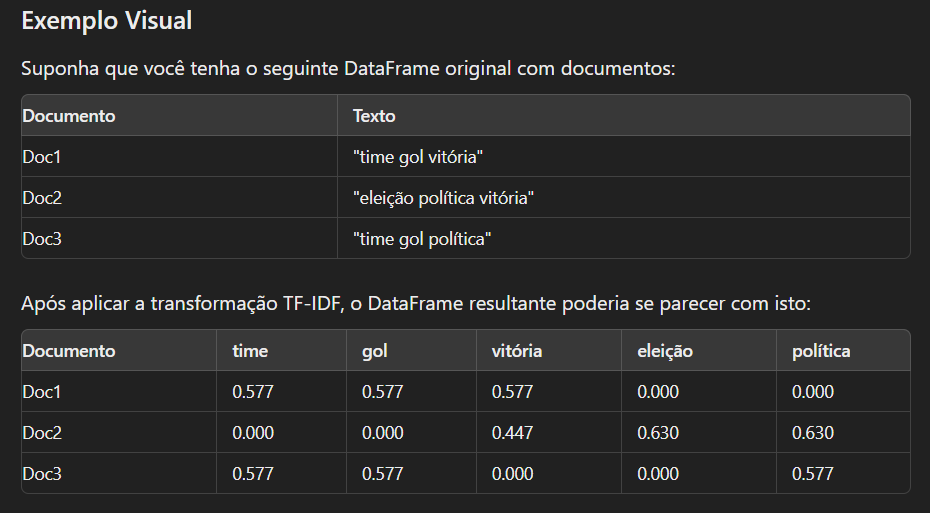

In [ ]:
# Transformar os textos em vetores TF-IDF
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df['clean_text'])

# O alvo é a coluna 'target'
y = df['target']

# Binarização das saidas
y_binary = label_binarize(y, classes=[0, 4]).reshape(-1)

> Divisão do DataSet em *treino* e *teste*.

In [ ]:
# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)
print("Tamanho do conjunto de treino:", X_train.shape)
print("Tamanho do conjunto de teste:", X_test.shape)

Tamanho do conjunto de treino: (1274049, 1000)
Tamanho do conjunto de teste: (318513, 1000)


> Treinamento dos modelos

In [ ]:
# Definir os modelos
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=400), # 400 pra ter certeza q vai convergir
    "Neural Network": MLPClassifier(max_iter=100, early_stopping=True)
}

melhores_estimadores = {}

# Treinamento e avaliação de cada modelo
for model_name, model in models.items():
    print(f"Treinando o modelo: {model_name}")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Acurácia do modelo {model_name}: {accuracy}")

    melhores_estimadores[model_name] = model

Treinando o modelo: Naive Bayes
Acurácia do modelo Naive Bayes: 0.7325540872743028
Treinando o modelo: Logistic Regression
Acurácia do modelo Logistic Regression: 0.7484027339543441
Treinando o modelo: Neural Network
Acurácia do modelo Neural Network: 0.759300248341512


## Validação Cruzada e Hiperparâmetros

> Após a avaliação dos modelos, o escolhido foi a Regressão Logística, pelo tempo de processamento e desempenho.

> Agora, resta realizar uma validação cruzada com diferentes hiperparâmetros e, enfim, encontrar a melhor combinação para o treinamento do modelo.

In [ ]:
# hiperparâmetros a serem testados
param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1],
        'solver': ['sag', 'newton-cg'],
        'penalty': ['l2']
    }
}

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(models['Logistic Regression'], param_grids['Logistic Regression'], cv=kf, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Melhores Hiperparâmetros para Regressão Logistica: {grid_search.best_params_}")

melhor_modelo = grid_search.best_estimator_

Melhores Hiperparâmetros para Regressão Logistica: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}


## Avaliação do modelo

Métricas por matrix de confusão:

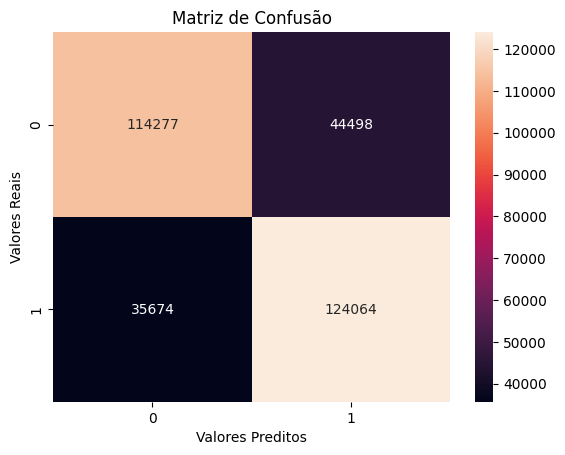

Regressão Logistica:
Acurácia: 0.7483, Precisão: 0.7490, Recall: 0.7483, F1-Score: 0.7481

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.76      0.72      0.74    158775
           1       0.74      0.78      0.76    159738

    accuracy                           0.75    318513
   macro avg       0.75      0.75      0.75    318513
weighted avg       0.75      0.75      0.75    318513



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
y_pred = melhor_modelo.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='rocket')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão')
plt.show()

print("Regressão Logistica:")
print(f"Acurácia: {accuracy:.4f}, Precisão: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}\n")
print("Relatório de Classificação:\n", report)

# Plotando a Matrix de Confusão e Curva ROC

> Curva ROC e AUC

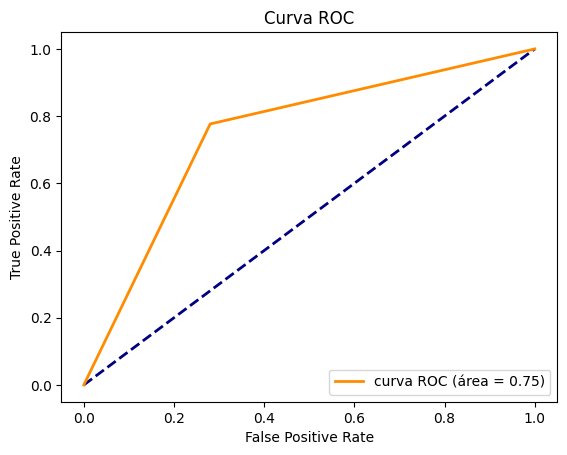

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# armazena os valores de metricas retornados pela função.
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# armazena a área sob curva
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr, tpr, color='darkorange', lw=2, label='curva ROC (área = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

> Matriz de Confusão

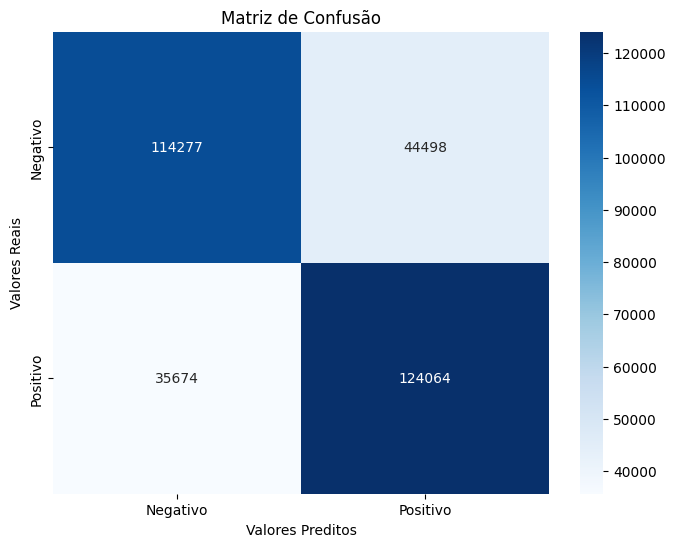

In [ ]:
from sklearn.metrics import confusion_matrix

# puxando os dados de tp, tn, fp e fn
cm = confusion_matrix(y_test, y_pred)

# plotando a matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão')
plt.show()

# Exportando o modelo

Usando a biblioteca **joblib**, é possivel fazer o export de modelos que realizam o treinamento com grandes arrays de forma simples.

Além do modelo já treinado, também exportamos o objeto da classe **tfidf**.

- Isso é mecessário, pois para novos inputs, o tfidf precisa calcular o pesso das novas palavras em relação as mesmas já usadas no treinamento do nosso modelo.

In [ ]:
import joblib

model = melhor_modelo

# salvar o modelo em um arquivo .pkl
joblib.dump(model, 'modelo.pkl')

joblib.dump(tfidf, 'vetor_tfidf.pkl')

# e para ara carregar o modelo novamente
model_carregado = joblib.load('modelo.pkl')


- **Sobre arquivos `.pkl`:** O .pkl é a extensão de arquivo associada ao formato de serialização pickle no Python. O pickle é um módulo do Python que permite serializar (converter) objetos Python em uma sequência de bytes que pode ser armazenada em um arquivo. Esse arquivo pode então ser carregado posteriormente, recriando o objeto original.